In [1]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [3]:
# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# NN-related
import torch

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML, Video
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True)
    # anim.save('test.mp4')
    # return Video(anim.to_html5_video(), embed=True)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\pylab\config.py:79: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


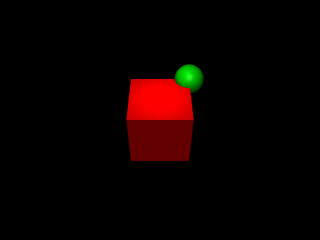

In [4]:
static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)


c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


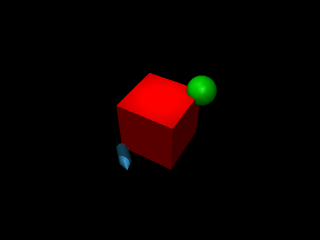

In [5]:
swinging_body = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [6]:
duration = 2    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


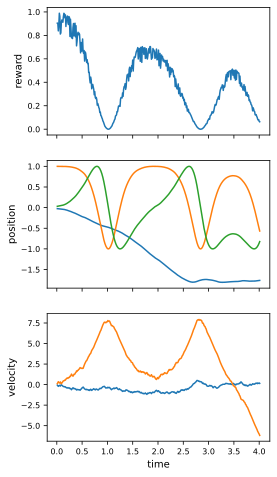

In [7]:
random_state = np.random.RandomState(42)
env = suite.load('cartpole', 'balance', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:

    action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
    time_step = env.step(action)

    camera0 = env.physics.render(camera_id=0, height=200, width=200)
    camera1 = env.physics.render(camera_id=1, height=200, width=200)
    frames.append(np.hstack((camera0, camera1)))
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)

html_video

In [8]:
from dm_control import viewer
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
  del time_step  # Unused.
  return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)
viewer.launch(env, policy=random_policy)

c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
  print(f'{domain:<{max_len}}  {task}')


acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run


c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run


c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
